In [1]:
using JLD2 
using Plots
using StatsBase
using Random

In [2]:
f = jldopen("../../Data/NASA_KeplerV2/datasets/KeplerLightCurveOrig.jld2", "r");
X_train = read(f, "X_train");
X_test = read(f, "X_test");
y_train = read(f, "y_train")
y_test = read(f, "y_test");

In [17]:
# merge data
Xs = vcat(X_train, X_test)
ys = vcat(y_train, y_test);
println(Xs.size)
println(ys.size)

(1319, 4767)
(1319,)


In [37]:
function detect_flat_regions(data)
    flat_regions = []
    for i in 2:length(data)
        if data[i] == data[i-1]
            push!(flat_regions, i)
        end
    end
    return flat_regions
end

detect_flat_regions (generic function with 1 method)

In [38]:
function make_overlapping_windows(ts::Vector{Float64}, window_size::Int, stride::Int)
    n = length(ts)
    windows = [ts[i:i+window_size-1] for i in 1:stride:n-window_size+1]
    return windows
end

make_overlapping_windows (generic function with 1 method)

In [69]:
function split_train_test(windows::Vector, exclude_indexes::Vector{Int}, test_size::Int)
    train_size = length(windows) - length(exclude_indexes) - test_size
    holdout_idxs = exclude_indexes
    remaining_indexes = setdiff(1:length(windows), exclude_indexes)
    # now select the training set from the remaining indices
    train_idxs = shuffle(remaining_indexes)[1:train_size]
    test_idxs = setdiff(remaining_indexes, train_idxs)
    return train_idxs, test_idxs, holdout_idxs
end

split_train_test (generic function with 1 method)

# Class 6

In [441]:
c6_idxs = findall(x -> x .== 6, ys);
println("Number of instances in class 6: $(length(c6_idxs))")

Number of instances in class 6: 25


Plot a 100 sample window from each instance

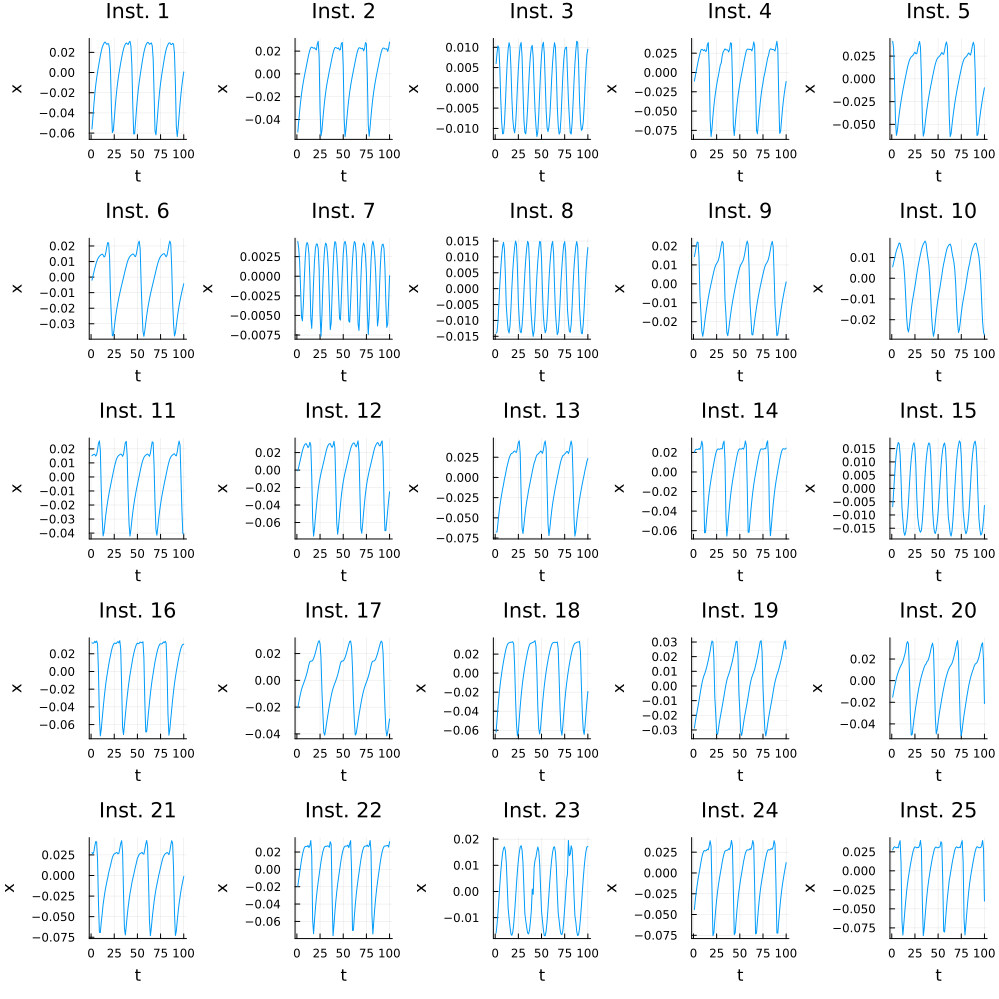

In [442]:
ps = []
for i in 1:length(c6_idxs)
    win = Xs[c6_idxs[i], 1:100]
    p = plot(win, title="Inst. $i", xlabel="t", ylabel="x", label="")
    push!(ps, p)
end
plot(ps..., size=(1000, 1000))

Assign instances to train/test

In [443]:
train = [1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25];
test = setdiff(collect(1:25), train);

Try to window single instance

In [444]:
Xs_c6 = Xs[c6_idxs, :];

In [445]:
instance1 = Xs_c6[1, :]
stride = 100 #non-overlapping
w = 100
windows = make_overlapping_windows(instance1, w, stride);

Detect the windows with artefacts

In [446]:
corrupted_window_idxs = findall(length.(detect_flat_regions.(windows)) .> 4);

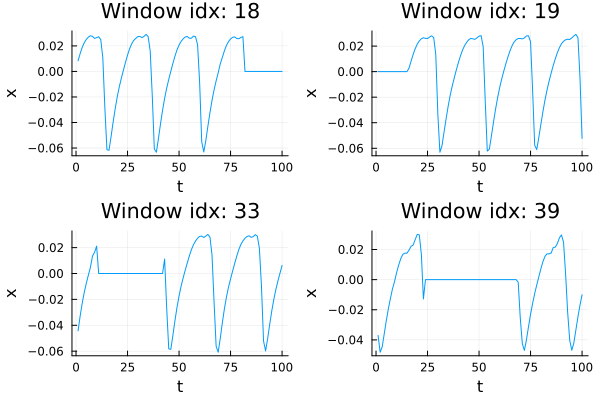

In [447]:
ps = []
for cidx in corrupted_window_idxs
    p = plot(windows[cidx], label="", xlabel="t", ylabel="x", title="Window idx: $cidx")
    push!(ps, p)
end
plot(ps...)

In [448]:
function make_train_test_split(Xs::Matrix{Float64}, train_idxs::Vector{Int64}, test_idxs::Vector{Int64}, 
        window_size::Int; include_artefacts=false, window_retain_fraction=1.0)
    # makes train test split using seperate instances
    X_train = []
    X_test = []
    discarded = 0
    # loop through each instance
    for i in train_idxs
        ts_instance = Xs[i, :] # isolate the time series of interest
        stride = window_size
        wins = make_overlapping_windows(ts_instance, window_size, stride) # window the data 
        corr_win_idxs = findall(length.(detect_flat_regions.(windows)) .> 8); # find windows with artefacts
        discarded += length(corr_win_idxs)
        train_window_idxs = setdiff(collect(1:length(wins)), corr_win_idxs)
        # take a fraction of the windows
        keep_num_windows = round(Int64, length(train_window_idxs)*window_retain_fraction)
        train_window_idxs_subset = sample(train_window_idxs, keep_num_windows; replace=false)
        train_windows = wins[train_window_idxs_subset]
        push!(X_train, train_windows...)
    end
    for j in test_idxs
        ts_instance = Xs[j, :] # isolate the time series of interest
        stride = window_size
        wins = make_overlapping_windows(ts_instance, window_size, stride) # window the data 
        corr_win_idxs = findall(length.(detect_flat_regions.(windows)) .> 8); # find windows with artefacts
        if include_artefacts
            push!(X_test, wins...)
        else
            discarded += length(corr_win_idxs)
            test_window_idxs = setdiff(collect(1:length(wins)), corr_win_idxs)
            test_windows = wins[test_window_idxs]
            push!(X_test, test_windows...)
        end
    end
    X_train_mat = vcat(X_train'...)
    y_train = zeros(Int64, size(X_train_mat, 1))
    X_test_mat = vcat(X_test'...)
    y_test = zeros(Int64, size(X_test_mat, 1))
    println("Final training set size: $(size(X_train_mat))")
    println("Final testing set size: $(size(X_test_mat))")
    println("Discarded $(discarded) windows which contained artefacts!")
    return X_train_mat, y_train, X_test_mat, y_test
end

make_train_test_split (generic function with 1 method)

In [450]:
X_train_f, y_train_f, X_test_f, y_test_f = make_train_test_split(Xs_c6, train, test, 100; include_artefacts=false, window_retain_fraction=0.8);

Final training set size: (714, 100)
Final testing set size: (172, 100)
Discarded 100 windows which contained artefacts!


In [451]:
jldopen("c6_impute_final.jld2", "w") do f
    f["X_train"] = X_train_f
    f["y_train"] = y_train_f
    f["X_test"] = X_test_f
    f["y_test"] = y_test_f
end;

In [99]:
#@save "c6_s19_impute_noholdout.jld2" X_train X_test y_train y_test

# Class 0

In [233]:
c0_idxs = findall(x -> x .== 0, ys);
println("Number of instances in class 0: $(length(c0_idxs))")

Number of instances in class 0: 171


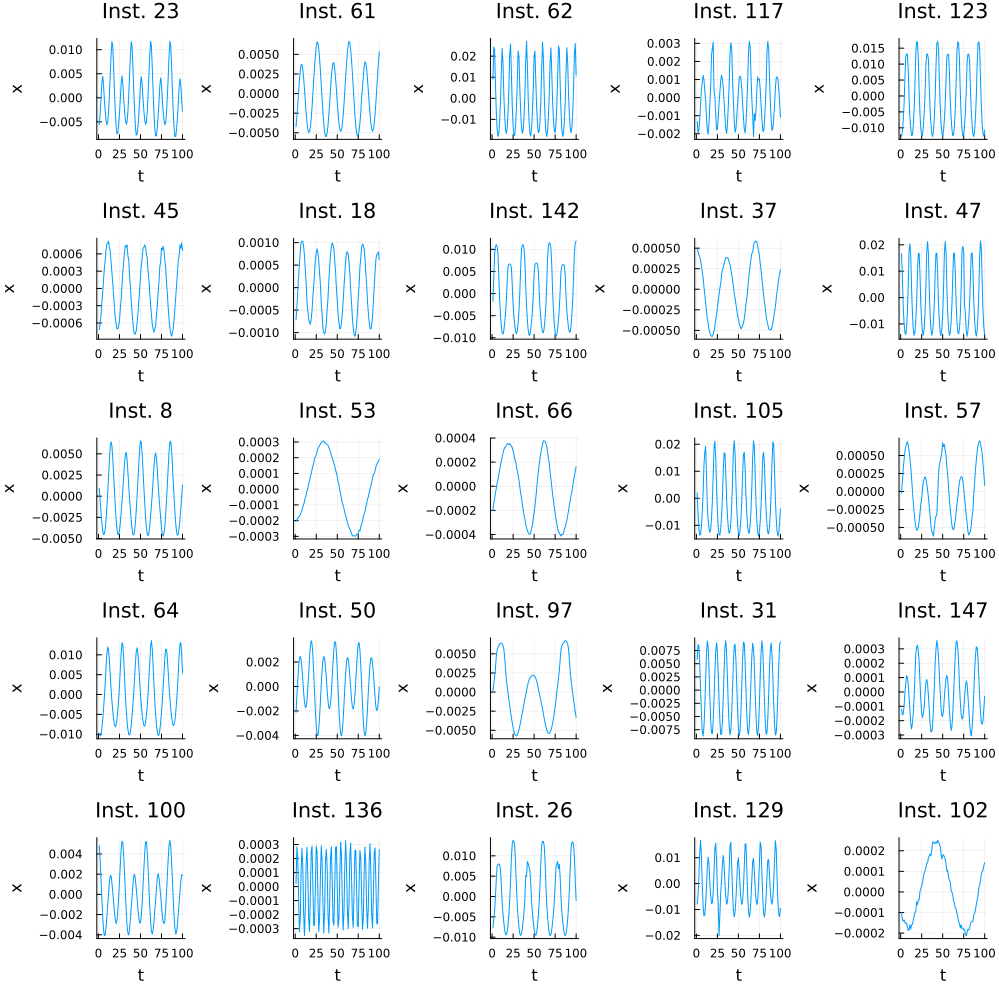

In [322]:
ps = []
for i in sample(1:length(c0_idxs), 25; replace=false)
    win = Xs[c0_idxs[i], 1:100]
    p = plot(win, title="Inst. $i", xlabel="t", ylabel="x", label="")
    push!(ps, p)
end
plot(ps..., size=(1000, 1000))

In [254]:
Xs_c0 = Xs[c0_idxs, :];

In [323]:
round(Int64, size(Xs_c0, 1) * 0.8)

137

In [431]:
Random.seed!(0)
train_idxs = sample(1:size(Xs_c0, 1), 80; replace=false);
test_idxs = setdiff(1:size(Xs_c0, 1), train_idxs);

In [439]:
X_train_c0, y_train_c0, X_test_c0, y_test_c0 = make_train_test_split(Xs_c0, train_idxs, test_idxs, 100; include_artefacts=false, window_retain_fraction=0.2);

Final training set size: (720, 100)
Final testing set size: (3913, 100)
Discarded 684 windows which contained artefacts!


In [440]:
jldopen("c0_impute_large3.jld2", "w") do f
    f["X_train"] = X_train_c0
    f["y_train"] = y_train_c0
    f["X_test"] = X_test_c0
    f["y_test"] = y_test_c0
end;

# Class 1

In [320]:
c3_idxs = findall(x -> x .== 3, ys);
println("Number of instances in class 3: $(length(c3_idxs))")

Number of instances in class 3: 262


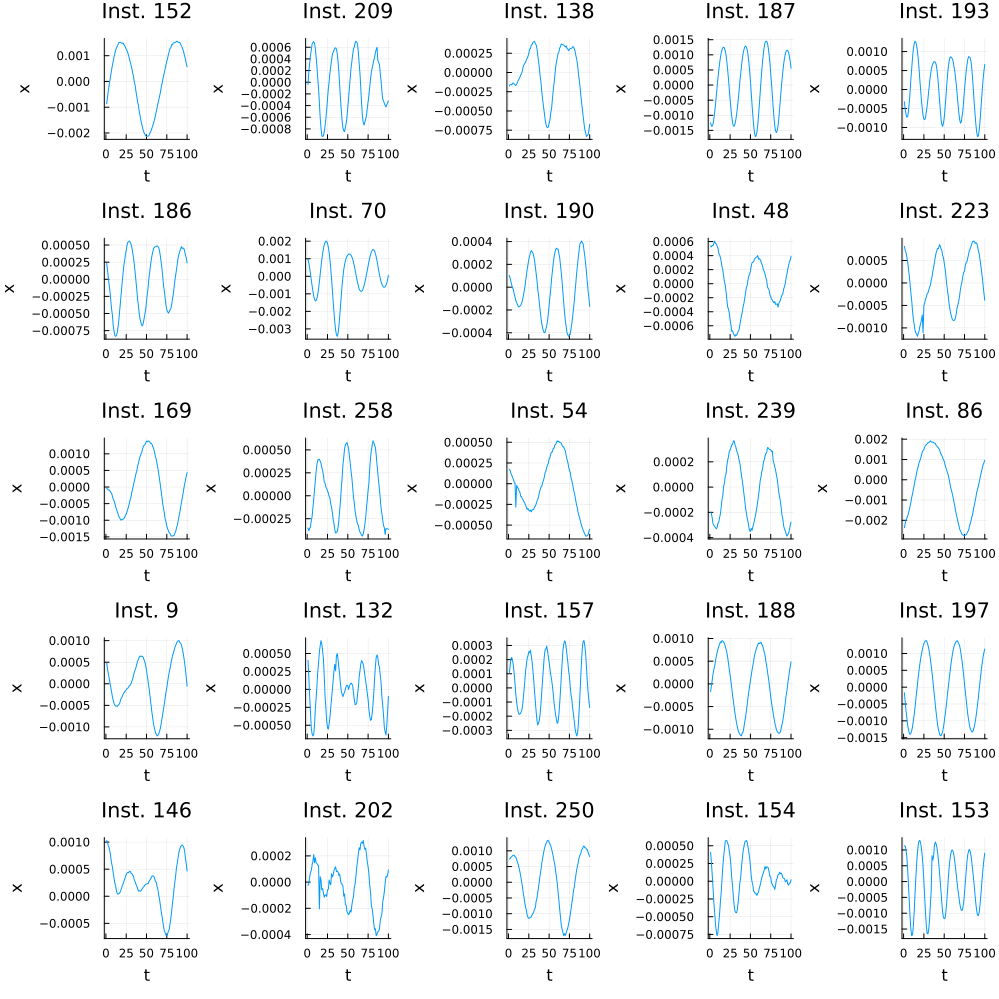

In [321]:
ps = []
for i in sample(1:length(c3_idxs), 25; replace=false)
    win = Xs[c3_idxs[i], 1:100]
    p = plot(win, title="Inst. $i", xlabel="t", ylabel="x", label="")
    push!(ps, p)
end
plot(ps..., size=(1000, 1000))